In [ ]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.6 MB/s eta 0:00:00


In [ ]:
root_dir = "/content/drive/Othercomputers/Mac/Mila/Winter_2023/ift6759_project/"

%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.append(root_dir)

Mounted at /content/drive


In [ ]:
from transformers import AutoFeatureExtractor
from torchvision import transforms

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

transform = transforms.Compose([
    transforms.Lambda(lambda pil_img: pil_img.convert("RGB")),
    transforms.Resize((feature_extractor.size["height"], feature_extractor.size["width"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from covidSeverityDataset import CovidSeverityDataset

dataset = CovidSeverityDataset(root_dir, batch_size = 8, transform=transform)
train_dataset, val_dataset, test_dataset = dataset.get_subsets()

In [ ]:
import torch

def to_device(tensors, device):
    if isinstance(tensors, torch.Tensor):
        return tensors.to(device=device)
    elif isinstance(tensors, dict):
        return dict(
            (key, to_device(tensor, device)) for (key, tensor) in tensors.items()
        )
    elif isinstance(tensors, list):
        return list(
            (to_device(tensors[0], device), to_device(tensors[1], device)))
    else:
        raise NotImplementedError("Unknown type {0}".format(type(tensors)))

def compute_accuracy(logits: torch.Tensor, labels: torch.Tensor):
    """ Compute the accuracy of the batch """
    acc = (logits.argmax(dim=1) == labels).float().mean()
    return acc

In [ ]:
from transformers import ViTForImageClassification

model_name_or_path = "google/vit-base-patch16-224-in21k"

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=7,
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
import time
import os
from tqdm.auto import tqdm
from torch import nn

def train(epoch, model, dataloader, optimizer, lr_scheduler, num_training_steps, print_every=80):
    model.train()
    total_iters = 0
    epoch_accuracy = 0
    epoch_loss = 0
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    progress_bar = tqdm(range(num_training_steps))

    for idx, batch in enumerate(dataloader):
        batch = to_device(batch, device)
        optimizer.zero_grad()
        imgs, labels = batch
        output = model(imgs)
        logits = output.logits

        loss = criterion(logits, labels)     
        acc = compute_accuracy(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        epoch_accuracy += acc.item() / len(dataloader)
        epoch_loss += loss.item() / len(dataloader)
        total_iters += 1
        progress_bar.update(idx)
        if idx % print_every == 0:
            tqdm.write(f"[TRAIN] Epoch: {epoch}, Iter: {idx}, Loss: {loss.item():.5f}")
    tqdm.write(f"== [TRAIN] Epoch: {epoch}, Accuracy: {epoch_accuracy:.3f} ==>")
    return epoch_loss, epoch_accuracy, time.time() - start_time

def evaluate(epoch, model, dataloader, mode="val", print_every=80):
    model.eval()
    epoch_accuracy=0
    epoch_loss=0
    total_iters = 0
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            batch = to_device(batch, device)
            imgs, labels = batch
            output = model(imgs)
            logits = output.logits

            loss = criterion(logits, labels)     
            acc = compute_accuracy(logits, labels)

            epoch_accuracy += acc.item() / len(dataloader)
            epoch_loss += loss.item() / len(dataloader)
            total_iters += 1
            if idx % print_every == 0:
                tqdm.write(
                    f"[{mode.upper()}] Epoch: {epoch}, Iter: {idx}, Loss: {loss.item():.5f}"
                )
        tqdm.write(
            f"=== [{mode.upper()}] Epoch: {epoch}, Iter: {idx}, Accuracy: {epoch_accuracy:.3f} ===>"
        )
    return epoch_loss, epoch_accuracy, time.time() - start_time

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

num_epochs = 20

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = num_epochs * len(train_dataset)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [9]:
from tqdm import tqdm

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
train_times, valid_times = [], []

for epoch in range(num_epochs):
    tqdm.write(f"====== Epoch {epoch} ======>")
    loss, acc, wall_time = train(epoch, model, train_dataset, optimizer, lr_scheduler, num_training_steps)
    train_losses.append(loss)
    train_accs.append(acc)
    train_times.append(wall_time)

    loss, acc, wall_time = evaluate(epoch, model, val_dataset)
    valid_losses.append(loss)
    valid_accs.append(acc)
    valid_times.append(wall_time)

    if epoch % 10 == 0:
      torch.save(model, root_dir + "luis_test/model_" + str(epoch) + ".h5")

test_loss, test_acc, test_time = evaluate(
    epoch, model, test_dataset, mode="test"
)
torch.save(model, root_dir + "luis_test/model.h5")

====== Epoch 0 ======>


  0%|          | 0/13794 [00:10<?, ?it/s]

[TRAIN] Epoch: 0, Iter: 0, Loss: 1.97932


 23%|██▎       | 3240/13794 [03:50<06:06, 28.82it/s]

[TRAIN] Epoch: 0, Iter: 80, Loss: 1.48916


 93%|█████████▎| 12880/13794 [07:31<00:16, 56.73it/s]

[TRAIN] Epoch: 0, Iter: 160, Loss: 1.25686


28920it [11:13, 86.74it/s]

[TRAIN] Epoch: 0, Iter: 240, Loss: 1.34680


51360it [14:52, 105.66it/s]

[TRAIN] Epoch: 0, Iter: 320, Loss: 1.85083


80200it [18:32, 144.68it/s]

[TRAIN] Epoch: 0, Iter: 400, Loss: 0.96929


115440it [22:11, 173.18it/s]

[TRAIN] Epoch: 0, Iter: 480, Loss: 1.36894


157080it [25:48, 208.29it/s]

[TRAIN] Epoch: 0, Iter: 560, Loss: 0.97890


196251it [28:45, 113.73it/s]


== [TRAIN] Epoch: 0, Accuracy: 0.422 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.50800
[VAL] Epoch: 0, Iter: 80, Loss: 1.19818
=== [VAL] Epoch: 0, Iter: 89, Accuracy: 0.485 ===>
====== Epoch 1 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 1, Iter: 0, Loss: 0.98167


 24%|██▍       | 3321/13794 [00:08<00:13, 779.48it/s]

[TRAIN] Epoch: 1, Iter: 80, Loss: 1.05735


 95%|█████████▍| 13041/13794 [00:15<00:00, 1590.13it/s]

[TRAIN] Epoch: 1, Iter: 160, Loss: 0.97233


29161it [00:23, 2414.86it/s]

[TRAIN] Epoch: 1, Iter: 240, Loss: 1.08877


51681it [00:31, 3322.16it/s]

[TRAIN] Epoch: 1, Iter: 320, Loss: 0.89928


80601it [00:39, 3999.71it/s]

[TRAIN] Epoch: 1, Iter: 400, Loss: 1.26030


115921it [00:46, 4838.61it/s]

[TRAIN] Epoch: 1, Iter: 480, Loss: 1.02854


157641it [00:54, 5746.39it/s]

[TRAIN] Epoch: 1, Iter: 560, Loss: 1.28115


196251it [01:00, 3218.58it/s]


== [TRAIN] Epoch: 1, Accuracy: 0.520 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.56239
[VAL] Epoch: 1, Iter: 80, Loss: 1.44015
=== [VAL] Epoch: 1, Iter: 89, Accuracy: 0.460 ===>
====== Epoch 2 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 2, Iter: 0, Loss: 1.17741


 24%|██▍       | 3321/13794 [00:07<00:13, 780.72it/s]

[TRAIN] Epoch: 2, Iter: 80, Loss: 1.23142


 95%|█████████▍| 13041/13794 [00:15<00:00, 1627.42it/s]

[TRAIN] Epoch: 2, Iter: 160, Loss: 0.61212


29161it [00:23, 2364.31it/s]

[TRAIN] Epoch: 2, Iter: 240, Loss: 1.46373


51681it [00:31, 3153.31it/s]

[TRAIN] Epoch: 2, Iter: 320, Loss: 0.81657


80601it [00:39, 3903.29it/s]

[TRAIN] Epoch: 2, Iter: 400, Loss: 0.51759


116403it [00:47, 4870.05it/s]

[TRAIN] Epoch: 2, Iter: 480, Loss: 1.49674


157641it [00:55, 5590.36it/s]

[TRAIN] Epoch: 2, Iter: 560, Loss: 0.93938


196251it [01:01, 3187.92it/s]


== [TRAIN] Epoch: 2, Accuracy: 0.625 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 1.98587
[VAL] Epoch: 2, Iter: 80, Loss: 1.70139
=== [VAL] Epoch: 2, Iter: 89, Accuracy: 0.497 ===>
====== Epoch 3 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 3, Iter: 0, Loss: 0.50957


 24%|██▍       | 3321/13794 [00:08<00:13, 768.69it/s]

[TRAIN] Epoch: 3, Iter: 80, Loss: 0.60968


 95%|█████████▍| 13041/13794 [00:16<00:00, 1578.76it/s]

[TRAIN] Epoch: 3, Iter: 160, Loss: 0.81658


29161it [00:24, 2372.54it/s]

[TRAIN] Epoch: 3, Iter: 240, Loss: 0.30567


52003it [00:32, 3198.26it/s]

[TRAIN] Epoch: 3, Iter: 320, Loss: 0.49921


80601it [00:40, 3962.12it/s]

[TRAIN] Epoch: 3, Iter: 400, Loss: 0.71024


115921it [00:48, 4703.12it/s]

[TRAIN] Epoch: 3, Iter: 480, Loss: 0.76575


158203it [00:56, 5608.73it/s]

[TRAIN] Epoch: 3, Iter: 560, Loss: 0.67412


196251it [01:02, 3137.14it/s]


== [TRAIN] Epoch: 3, Accuracy: 0.750 ==>
[VAL] Epoch: 3, Iter: 0, Loss: 2.05636
[VAL] Epoch: 3, Iter: 80, Loss: 1.90840
=== [VAL] Epoch: 3, Iter: 89, Accuracy: 0.485 ===>
====== Epoch 4 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 4, Iter: 0, Loss: 0.33523


 24%|██▍       | 3321/13794 [00:08<00:13, 754.86it/s]

[TRAIN] Epoch: 4, Iter: 80, Loss: 0.25200


 95%|█████████▍| 13041/13794 [00:16<00:00, 1550.22it/s]

[TRAIN] Epoch: 4, Iter: 160, Loss: 0.70569


29161it [00:24, 2330.54it/s]

[TRAIN] Epoch: 4, Iter: 240, Loss: 0.53781


51681it [00:32, 3151.32it/s]

[TRAIN] Epoch: 4, Iter: 320, Loss: 0.40058


80601it [00:40, 3924.15it/s]

[TRAIN] Epoch: 4, Iter: 400, Loss: 0.41769


115921it [00:48, 4670.85it/s]

[TRAIN] Epoch: 4, Iter: 480, Loss: 0.39342


158203it [00:56, 5626.85it/s]

[TRAIN] Epoch: 4, Iter: 560, Loss: 0.15940


196251it [01:02, 3119.42it/s]


== [TRAIN] Epoch: 4, Accuracy: 0.849 ==>
[VAL] Epoch: 4, Iter: 0, Loss: 1.75894
[VAL] Epoch: 4, Iter: 80, Loss: 1.88046
=== [VAL] Epoch: 4, Iter: 89, Accuracy: 0.482 ===>
====== Epoch 5 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 5, Iter: 0, Loss: 0.32985


 24%|██▍       | 3321/13794 [00:08<00:13, 771.97it/s]

[TRAIN] Epoch: 5, Iter: 80, Loss: 0.12756


 95%|█████████▍| 13041/13794 [00:15<00:00, 1587.06it/s]

[TRAIN] Epoch: 5, Iter: 160, Loss: 0.07792


29161it [00:23, 2380.50it/s]

[TRAIN] Epoch: 5, Iter: 240, Loss: 0.17076


51360it [00:31, 3255.81it/s]

[TRAIN] Epoch: 5, Iter: 320, Loss: 0.34053


81003it [00:39, 4096.23it/s]

[TRAIN] Epoch: 5, Iter: 400, Loss: 0.12174


116403it [00:47, 4814.47it/s]

[TRAIN] Epoch: 5, Iter: 480, Loss: 0.05590


157080it [00:54, 5807.32it/s]

[TRAIN] Epoch: 5, Iter: 560, Loss: 0.56596


196251it [01:01, 3212.67it/s]


== [TRAIN] Epoch: 5, Accuracy: 0.913 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 2.75102
[VAL] Epoch: 5, Iter: 80, Loss: 2.23398
=== [VAL] Epoch: 5, Iter: 89, Accuracy: 0.478 ===>
====== Epoch 6 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 6, Iter: 0, Loss: 0.06700


 24%|██▍       | 3321/13794 [00:08<00:13, 769.36it/s]

[TRAIN] Epoch: 6, Iter: 80, Loss: 0.04452


 95%|█████████▍| 13041/13794 [00:15<00:00, 1584.01it/s]

[TRAIN] Epoch: 6, Iter: 160, Loss: 0.07238


29403it [00:23, 2437.30it/s]

[TRAIN] Epoch: 6, Iter: 240, Loss: 0.15325


52003it [00:31, 3192.84it/s]

[TRAIN] Epoch: 6, Iter: 320, Loss: 0.12386


80601it [00:39, 3884.55it/s]

[TRAIN] Epoch: 6, Iter: 400, Loss: 0.02485


115921it [00:47, 4695.64it/s]

[TRAIN] Epoch: 6, Iter: 480, Loss: 0.06003


157641it [00:55, 5613.45it/s]

[TRAIN] Epoch: 6, Iter: 560, Loss: 0.09143


196251it [01:01, 3183.25it/s]


== [TRAIN] Epoch: 6, Accuracy: 0.936 ==>
[VAL] Epoch: 6, Iter: 0, Loss: 3.21204
[VAL] Epoch: 6, Iter: 80, Loss: 2.54575
=== [VAL] Epoch: 6, Iter: 89, Accuracy: 0.496 ===>
====== Epoch 7 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 7, Iter: 0, Loss: 0.03028


 24%|██▍       | 3321/13794 [00:08<00:13, 761.91it/s]

[TRAIN] Epoch: 7, Iter: 80, Loss: 0.11146


 95%|█████████▍| 13041/13794 [00:16<00:00, 1598.61it/s]

[TRAIN] Epoch: 7, Iter: 160, Loss: 0.03165


29161it [00:24, 2395.60it/s]

[TRAIN] Epoch: 7, Iter: 240, Loss: 0.03967


51681it [00:32, 3091.16it/s]

[TRAIN] Epoch: 7, Iter: 320, Loss: 0.24890


80601it [00:40, 3888.99it/s]

[TRAIN] Epoch: 7, Iter: 400, Loss: 0.03331


115921it [00:48, 4768.52it/s]

[TRAIN] Epoch: 7, Iter: 480, Loss: 0.02072


157641it [00:56, 5571.43it/s]

[TRAIN] Epoch: 7, Iter: 560, Loss: 0.02115


196251it [01:02, 3128.80it/s]


== [TRAIN] Epoch: 7, Accuracy: 0.958 ==>
[VAL] Epoch: 7, Iter: 0, Loss: 2.87163
[VAL] Epoch: 7, Iter: 80, Loss: 2.36864
=== [VAL] Epoch: 7, Iter: 89, Accuracy: 0.474 ===>
====== Epoch 8 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 8, Iter: 0, Loss: 0.86265


 24%|██▍       | 3321/13794 [00:08<00:13, 776.50it/s]

[TRAIN] Epoch: 8, Iter: 80, Loss: 0.15322


 95%|█████████▍| 13041/13794 [00:16<00:00, 1581.56it/s]

[TRAIN] Epoch: 8, Iter: 160, Loss: 0.03947


29161it [00:24, 2397.05it/s]

[TRAIN] Epoch: 8, Iter: 240, Loss: 0.01551


51681it [00:32, 3119.16it/s]

[TRAIN] Epoch: 8, Iter: 320, Loss: 0.04848


80601it [00:40, 3921.85it/s]

[TRAIN] Epoch: 8, Iter: 400, Loss: 0.02554


115921it [00:48, 4691.74it/s]

[TRAIN] Epoch: 8, Iter: 480, Loss: 0.01619


157641it [00:56, 5549.25it/s]

[TRAIN] Epoch: 8, Iter: 560, Loss: 0.43423


196251it [01:02, 3130.50it/s]


== [TRAIN] Epoch: 8, Accuracy: 0.973 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 3.34246
[VAL] Epoch: 8, Iter: 80, Loss: 2.44034
=== [VAL] Epoch: 8, Iter: 89, Accuracy: 0.481 ===>
====== Epoch 9 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 9, Iter: 0, Loss: 0.04937


 24%|██▍       | 3321/13794 [00:08<00:13, 768.29it/s]

[TRAIN] Epoch: 9, Iter: 80, Loss: 0.06451


 95%|█████████▍| 13041/13794 [00:16<00:00, 1567.56it/s]

[TRAIN] Epoch: 9, Iter: 160, Loss: 0.01403


29161it [00:23, 2402.53it/s]

[TRAIN] Epoch: 9, Iter: 240, Loss: 0.01310


51681it [00:31, 3221.97it/s]

[TRAIN] Epoch: 9, Iter: 320, Loss: 0.03170


80601it [00:39, 4002.12it/s]

[TRAIN] Epoch: 9, Iter: 400, Loss: 0.01925


116403it [00:47, 4853.89it/s]

[TRAIN] Epoch: 9, Iter: 480, Loss: 0.02212


158203it [00:55, 5619.63it/s]

[TRAIN] Epoch: 9, Iter: 560, Loss: 0.00848


196251it [01:01, 3203.74it/s]


== [TRAIN] Epoch: 9, Accuracy: 0.982 ==>
[VAL] Epoch: 9, Iter: 0, Loss: 3.73765
[VAL] Epoch: 9, Iter: 80, Loss: 2.69989
=== [VAL] Epoch: 9, Iter: 89, Accuracy: 0.461 ===>
====== Epoch 10 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 10, Iter: 0, Loss: 0.01622


 24%|██▍       | 3321/13794 [00:08<00:13, 776.31it/s]

[TRAIN] Epoch: 10, Iter: 80, Loss: 0.00811


 95%|█████████▍| 13041/13794 [00:15<00:00, 1585.46it/s]

[TRAIN] Epoch: 10, Iter: 160, Loss: 0.01644


29161it [00:23, 2424.68it/s]

[TRAIN] Epoch: 10, Iter: 240, Loss: 0.00762


51681it [00:31, 3222.91it/s]

[TRAIN] Epoch: 10, Iter: 320, Loss: 0.00992


80601it [00:39, 3989.72it/s]

[TRAIN] Epoch: 10, Iter: 400, Loss: 0.00838


115921it [00:46, 4858.06it/s]

[TRAIN] Epoch: 10, Iter: 480, Loss: 0.11742


157641it [00:54, 5418.06it/s]

[TRAIN] Epoch: 10, Iter: 560, Loss: 0.00753


196251it [01:01, 3199.87it/s]


== [TRAIN] Epoch: 10, Accuracy: 0.987 ==>
[VAL] Epoch: 10, Iter: 0, Loss: 3.96191
[VAL] Epoch: 10, Iter: 80, Loss: 2.30189
=== [VAL] Epoch: 10, Iter: 89, Accuracy: 0.454 ===>
====== Epoch 11 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 11, Iter: 0, Loss: 0.02079


 24%|██▍       | 3321/13794 [00:08<00:13, 771.62it/s]

[TRAIN] Epoch: 11, Iter: 80, Loss: 0.03702


 95%|█████████▍| 13041/13794 [00:16<00:00, 1595.87it/s]

[TRAIN] Epoch: 11, Iter: 160, Loss: 0.02039


29403it [00:24, 2420.24it/s]

[TRAIN] Epoch: 11, Iter: 240, Loss: 0.00731


51681it [00:32, 3149.69it/s]

[TRAIN] Epoch: 11, Iter: 320, Loss: 0.01103


80601it [00:40, 3813.43it/s]

[TRAIN] Epoch: 11, Iter: 400, Loss: 0.06379


115921it [00:48, 4780.94it/s]

[TRAIN] Epoch: 11, Iter: 480, Loss: 0.00665


157641it [00:56, 5480.10it/s]

[TRAIN] Epoch: 11, Iter: 560, Loss: 0.00621


196251it [01:02, 3137.36it/s]


== [TRAIN] Epoch: 11, Accuracy: 0.989 ==>
[VAL] Epoch: 11, Iter: 0, Loss: 3.81525
[VAL] Epoch: 11, Iter: 80, Loss: 2.18991
=== [VAL] Epoch: 11, Iter: 89, Accuracy: 0.471 ===>
====== Epoch 12 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 12, Iter: 0, Loss: 0.06945


 24%|██▍       | 3321/13794 [00:08<00:13, 773.62it/s]

[TRAIN] Epoch: 12, Iter: 80, Loss: 0.00620


 96%|█████████▌| 13203/13794 [00:16<00:00, 1574.62it/s]

[TRAIN] Epoch: 12, Iter: 160, Loss: 0.00707


29161it [00:24, 2272.03it/s]

[TRAIN] Epoch: 12, Iter: 240, Loss: 0.01174


51681it [00:32, 3092.96it/s]

[TRAIN] Epoch: 12, Iter: 320, Loss: 0.00941


80601it [00:40, 4047.45it/s]

[TRAIN] Epoch: 12, Iter: 400, Loss: 0.06147


115921it [00:48, 4653.67it/s]

[TRAIN] Epoch: 12, Iter: 480, Loss: 0.00549


157641it [00:56, 5445.71it/s]

[TRAIN] Epoch: 12, Iter: 560, Loss: 0.01328


196251it [01:02, 3133.94it/s]


== [TRAIN] Epoch: 12, Accuracy: 0.987 ==>
[VAL] Epoch: 12, Iter: 0, Loss: 4.49617
[VAL] Epoch: 12, Iter: 80, Loss: 2.12747
=== [VAL] Epoch: 12, Iter: 89, Accuracy: 0.492 ===>
====== Epoch 13 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 13, Iter: 0, Loss: 0.02015


 25%|██▍       | 3403/13794 [00:08<00:13, 786.34it/s]

[TRAIN] Epoch: 13, Iter: 80, Loss: 0.01380


 95%|█████████▍| 13041/13794 [00:16<00:00, 1568.70it/s]

[TRAIN] Epoch: 13, Iter: 160, Loss: 0.00723


29161it [00:24, 2299.86it/s]

[TRAIN] Epoch: 13, Iter: 240, Loss: 0.01901


52003it [00:32, 3283.83it/s]

[TRAIN] Epoch: 13, Iter: 320, Loss: 0.00499


80601it [00:39, 4008.62it/s]

[TRAIN] Epoch: 13, Iter: 400, Loss: 0.00456


115921it [00:47, 4836.38it/s]

[TRAIN] Epoch: 13, Iter: 480, Loss: 0.00540


157641it [00:55, 5627.61it/s]

[TRAIN] Epoch: 13, Iter: 560, Loss: 0.00605


196251it [01:01, 3174.33it/s]


== [TRAIN] Epoch: 13, Accuracy: 0.996 ==>
[VAL] Epoch: 13, Iter: 0, Loss: 4.48164
[VAL] Epoch: 13, Iter: 80, Loss: 2.13085
=== [VAL] Epoch: 13, Iter: 89, Accuracy: 0.494 ===>
====== Epoch 14 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 14, Iter: 0, Loss: 0.00448


 24%|██▍       | 3321/13794 [00:07<00:13, 773.91it/s]

[TRAIN] Epoch: 14, Iter: 80, Loss: 0.00684


 95%|█████████▍| 13041/13794 [00:15<00:00, 1589.67it/s]

[TRAIN] Epoch: 14, Iter: 160, Loss: 0.00346


29161it [00:23, 2421.70it/s]

[TRAIN] Epoch: 14, Iter: 240, Loss: 0.00441


51681it [00:31, 3232.89it/s]

[TRAIN] Epoch: 14, Iter: 320, Loss: 0.00537


80601it [00:39, 4062.18it/s]

[TRAIN] Epoch: 14, Iter: 400, Loss: 0.00926


115921it [00:46, 4849.83it/s]

[TRAIN] Epoch: 14, Iter: 480, Loss: 0.00373


157641it [00:54, 5667.92it/s]

[TRAIN] Epoch: 14, Iter: 560, Loss: 0.17909


196251it [01:00, 3224.03it/s]


== [TRAIN] Epoch: 14, Accuracy: 0.997 ==>
[VAL] Epoch: 14, Iter: 0, Loss: 4.62962
[VAL] Epoch: 14, Iter: 80, Loss: 2.59579
=== [VAL] Epoch: 14, Iter: 89, Accuracy: 0.486 ===>
====== Epoch 15 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 15, Iter: 0, Loss: 0.00417


 25%|██▍       | 3403/13794 [00:08<00:13, 778.19it/s]

[TRAIN] Epoch: 15, Iter: 80, Loss: 0.00347


 96%|█████████▌| 13203/13794 [00:16<00:00, 1600.39it/s]

[TRAIN] Epoch: 15, Iter: 160, Loss: 0.00417


29161it [00:23, 2329.12it/s]

[TRAIN] Epoch: 15, Iter: 240, Loss: 0.00408


51681it [00:31, 3170.05it/s]

[TRAIN] Epoch: 15, Iter: 320, Loss: 0.00363


80601it [00:39, 3996.67it/s]

[TRAIN] Epoch: 15, Iter: 400, Loss: 0.00330


115921it [00:47, 4776.57it/s]

[TRAIN] Epoch: 15, Iter: 480, Loss: 0.00467


157641it [00:55, 5574.95it/s]

[TRAIN] Epoch: 15, Iter: 560, Loss: 0.00307


196251it [01:02, 3150.78it/s]


== [TRAIN] Epoch: 15, Accuracy: 0.995 ==>
[VAL] Epoch: 15, Iter: 0, Loss: 4.62715
[VAL] Epoch: 15, Iter: 80, Loss: 2.36443
=== [VAL] Epoch: 15, Iter: 89, Accuracy: 0.481 ===>
====== Epoch 16 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 16, Iter: 0, Loss: 0.00436


 24%|██▍       | 3321/13794 [00:08<00:13, 766.03it/s]

[TRAIN] Epoch: 16, Iter: 80, Loss: 0.00463


 95%|█████████▍| 13041/13794 [00:16<00:00, 1556.96it/s]

[TRAIN] Epoch: 16, Iter: 160, Loss: 0.00273


29161it [00:24, 2361.30it/s]

[TRAIN] Epoch: 16, Iter: 240, Loss: 0.00345


52003it [00:32, 3118.60it/s]

[TRAIN] Epoch: 16, Iter: 320, Loss: 0.00283


81003it [00:40, 3980.38it/s]

[TRAIN] Epoch: 16, Iter: 400, Loss: 0.00253


115921it [00:47, 4830.10it/s]

[TRAIN] Epoch: 16, Iter: 480, Loss: 0.03678


157641it [00:55, 5519.73it/s]

[TRAIN] Epoch: 16, Iter: 560, Loss: 0.00248


196251it [01:02, 3148.71it/s]


== [TRAIN] Epoch: 16, Accuracy: 0.997 ==>
[VAL] Epoch: 16, Iter: 0, Loss: 4.79302
[VAL] Epoch: 16, Iter: 80, Loss: 2.59234
=== [VAL] Epoch: 16, Iter: 89, Accuracy: 0.489 ===>
====== Epoch 17 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 17, Iter: 0, Loss: 0.00291


 24%|██▍       | 3321/13794 [00:08<00:13, 772.63it/s]

[TRAIN] Epoch: 17, Iter: 80, Loss: 0.00223


 95%|█████████▍| 13041/13794 [00:16<00:00, 1553.95it/s]

[TRAIN] Epoch: 17, Iter: 160, Loss: 0.00333


29161it [00:24, 2352.77it/s]

[TRAIN] Epoch: 17, Iter: 240, Loss: 0.00236


51681it [00:32, 3143.36it/s]

[TRAIN] Epoch: 17, Iter: 320, Loss: 0.00330


80601it [00:40, 3990.50it/s]

[TRAIN] Epoch: 17, Iter: 400, Loss: 0.00380


116403it [00:48, 4900.83it/s]

[TRAIN] Epoch: 17, Iter: 480, Loss: 0.00262


158203it [00:56, 5668.26it/s]

[TRAIN] Epoch: 17, Iter: 560, Loss: 0.00390


196251it [01:02, 3144.88it/s]


== [TRAIN] Epoch: 17, Accuracy: 0.999 ==>
[VAL] Epoch: 17, Iter: 0, Loss: 4.94679
[VAL] Epoch: 17, Iter: 80, Loss: 2.61364
=== [VAL] Epoch: 17, Iter: 89, Accuracy: 0.499 ===>
====== Epoch 18 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 18, Iter: 0, Loss: 0.00445


 24%|██▍       | 3321/13794 [00:07<00:13, 785.26it/s]

[TRAIN] Epoch: 18, Iter: 80, Loss: 0.00222


 95%|█████████▍| 13041/13794 [00:15<00:00, 1584.59it/s]

[TRAIN] Epoch: 18, Iter: 160, Loss: 0.00289


29161it [00:23, 2422.55it/s]

[TRAIN] Epoch: 18, Iter: 240, Loss: 0.00239


52003it [00:31, 3276.20it/s]

[TRAIN] Epoch: 18, Iter: 320, Loss: 0.00213


81003it [00:39, 4093.23it/s]

[TRAIN] Epoch: 18, Iter: 400, Loss: 0.00235


116403it [00:46, 4903.05it/s]

[TRAIN] Epoch: 18, Iter: 480, Loss: 0.00215


157080it [00:54, 5673.36it/s]

[TRAIN] Epoch: 18, Iter: 560, Loss: 0.00219


196251it [01:00, 3228.61it/s]


== [TRAIN] Epoch: 18, Accuracy: 1.000 ==>
[VAL] Epoch: 18, Iter: 0, Loss: 4.99396
[VAL] Epoch: 18, Iter: 80, Loss: 2.65915
=== [VAL] Epoch: 18, Iter: 89, Accuracy: 0.496 ===>
====== Epoch 19 ======>


  0%|          | 1/13794 [00:00<44:43,  5.14it/s]

[TRAIN] Epoch: 19, Iter: 0, Loss: 0.00322


 25%|██▍       | 3403/13794 [00:08<00:13, 780.20it/s]

[TRAIN] Epoch: 19, Iter: 80, Loss: 0.00204


 95%|█████████▍| 13041/13794 [00:15<00:00, 1562.22it/s]

[TRAIN] Epoch: 19, Iter: 160, Loss: 0.00203


29161it [00:23, 2362.82it/s]

[TRAIN] Epoch: 19, Iter: 240, Loss: 0.00181


51681it [00:31, 3131.04it/s]

[TRAIN] Epoch: 19, Iter: 320, Loss: 0.00241


80601it [00:39, 3967.80it/s]

[TRAIN] Epoch: 19, Iter: 400, Loss: 0.00175


115921it [00:47, 4698.29it/s]

[TRAIN] Epoch: 19, Iter: 480, Loss: 0.00179


157641it [00:55, 5498.65it/s]

[TRAIN] Epoch: 19, Iter: 560, Loss: 0.00240


196251it [01:02, 3158.07it/s]


== [TRAIN] Epoch: 19, Accuracy: 1.000 ==>
[VAL] Epoch: 19, Iter: 0, Loss: 5.05926
[VAL] Epoch: 19, Iter: 80, Loss: 2.69399
=== [VAL] Epoch: 19, Iter: 89, Accuracy: 0.496 ===>
====== Epoch 20 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 20, Iter: 0, Loss: 0.00226


 24%|██▍       | 3321/13794 [00:08<00:13, 774.46it/s]

[TRAIN] Epoch: 20, Iter: 80, Loss: 0.00220


 95%|█████████▍| 13041/13794 [00:16<00:00, 1541.56it/s]

[TRAIN] Epoch: 20, Iter: 160, Loss: 0.00237


29403it [00:24, 2371.07it/s]

[TRAIN] Epoch: 20, Iter: 240, Loss: 0.00180


51681it [00:32, 3170.66it/s]

[TRAIN] Epoch: 20, Iter: 320, Loss: 0.00198


80601it [00:40, 3899.59it/s]

[TRAIN] Epoch: 20, Iter: 400, Loss: 0.00267


115440it [00:48, 4864.16it/s]

[TRAIN] Epoch: 20, Iter: 480, Loss: 0.00182


157641it [00:56, 5514.32it/s]

[TRAIN] Epoch: 20, Iter: 560, Loss: 0.00154


196251it [01:02, 3138.19it/s]


== [TRAIN] Epoch: 20, Accuracy: 1.000 ==>
[VAL] Epoch: 20, Iter: 0, Loss: 5.10488
[VAL] Epoch: 20, Iter: 80, Loss: 2.71821
=== [VAL] Epoch: 20, Iter: 89, Accuracy: 0.496 ===>
====== Epoch 21 ======>


  0%|          | 0/13794 [00:00<?, ?it/s]

[TRAIN] Epoch: 21, Iter: 0, Loss: 0.00155


 24%|██▍       | 3321/13794 [00:08<00:13, 773.58it/s]

[TRAIN] Epoch: 21, Iter: 80, Loss: 0.00165


 95%|█████████▍| 13041/13794 [00:16<00:00, 1556.74it/s]

[TRAIN] Epoch: 21, Iter: 160, Loss: 0.00220


29403it [00:24, 2363.50it/s]

[TRAIN] Epoch: 21, Iter: 240, Loss: 0.00172


51681it [00:32, 3097.02it/s]

[TRAIN] Epoch: 21, Iter: 320, Loss: 0.00181


80601it [00:40, 3809.46it/s]

[TRAIN] Epoch: 21, Iter: 400, Loss: 0.00179


115921it [00:48, 4811.26it/s]

[TRAIN] Epoch: 21, Iter: 480, Loss: 0.00147


157641it [00:56, 5365.86it/s]

[TRAIN] Epoch: 21, Iter: 560, Loss: 0.00168


196251it [01:03, 3113.20it/s]


== [TRAIN] Epoch: 21, Accuracy: 1.000 ==>
[VAL] Epoch: 21, Iter: 0, Loss: 5.12275
[VAL] Epoch: 21, Iter: 80, Loss: 2.72797
=== [VAL] Epoch: 21, Iter: 89, Accuracy: 0.494 ===>
[TEST] Epoch: 21, Iter: 0, Loss: 3.35781
[TEST] Epoch: 21, Iter: 80, Loss: 3.64596
[TEST] Epoch: 21, Iter: 160, Loss: 2.76668
=== [TEST] Epoch: 21, Iter: 178, Accuracy: 0.492 ===>


In [10]:
import pickle

with open(root_dir + 'luis_test/results.pkl', 'wb') as f:
  pickle.dump({
      "train_losses": train_losses,
      "valid_losses": valid_losses,
      "train_accs": train_accs,
      "valid_accs": valid_accs,
      "train_times": train_times,
      "valid_times": valid_times,
  }, f)

<Axes: ylabel='Frequency'>

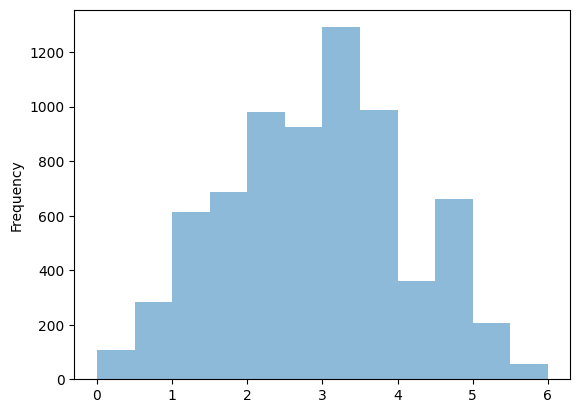

In [22]:
df = dataset.dataframe["OpacityScoreGlobal"]
df.plot.hist(bins=12, alpha=0.5)

## Results

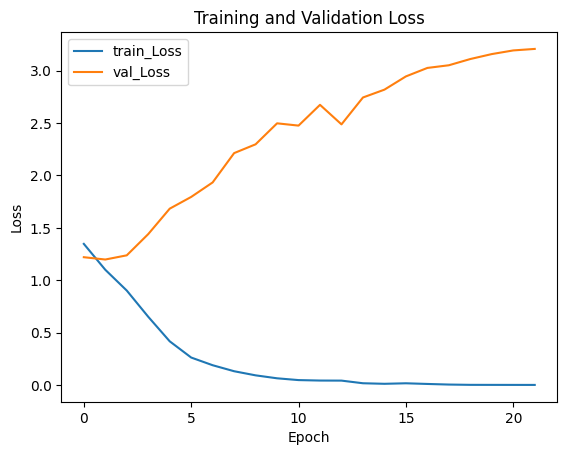

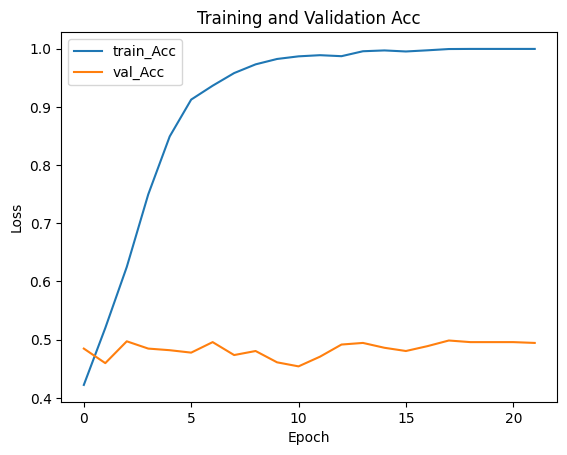

In [13]:
import matplotlib.pyplot as plt

def plot_results(train_result, val_results, type_results):
  plt.title("Training and Validation " + type_results)
  plt.plot(train_result, label="train_" + type_results)
  plt.plot(val_results, label="val_" + type_results)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

plot_results(train_losses, valid_losses, "Loss")
plot_results(train_accs, valid_accs, "Acc")